In [1]:
import sys
if not '../..' in sys.path:
    sys.path.append('../..')

from pathlib import Path
from analysis import emg, analysis, collection, plot
import numpy as np
from scipy.spatial import distance
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import tukey_hsd
from sklearn.decomposition import PCA

image_path = Path("/Users/spencer/phd/phd/images/basic_results/pca_dimensionality")

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams.update({'axes.labelsize': 16})
mpl.rcParams.update({'figure.figsize': (16*0.8,9*0.8)})
mpl.rcParams.update({'axes.facecolor': "white"})
mpl.rcParams.update({'lines.marker': "+"})
mpl.rcParams.update({'lines.linestyle': ""})
mpl.rcParams.update({"axes.spines.left":   True})
mpl.rcParams.update({"axes.spines.bottom": True})
mpl.rcParams.update({"axes.spines.top":    False})
mpl.rcParams.update({"axes.spines.right":  False})

%matplotlib inline

In [2]:
subjects = analysis.load_subjects()

In [3]:
import pandas as pd
trajectory_df = pd.read_pickle("../trajectory_dataframe.pkl")
mean_rewards = 1 / trajectory_df.groupby(level=['subject']).mean()["reward"]

### PCA dimenstionality for movement, calibration, trial chunks -- inspect relative, compare over subjects vs. reward

In [4]:
subject_idx = 0

movement_stack = np.load("../subject_filtered_movement_stacks.npy")[subject_idx]
calibration_stack = np.load("../subject_filtered_calibration_stacks.npy")[subject_idx]
trial_stack = np.load(f"../filtered_stacks/filtered_stack_{subject_idx}.npy")

print(movement_stack.shape, calibration_stack.shape, trial_stack.shape)

(2, 14, 64, 2000) (2, 32, 64, 2400) (45, 12, 64, 2000)


In [5]:
movement_samples = analysis.remove_nan_rows(movement_stack.transpose(0,1,3,2).reshape(-1,64))
calibration_samples = analysis.remove_nan_rows(calibration_stack.transpose(0,1,3,2).reshape(-1,64))

In [6]:
chunk_indices = list(zip(np.arange(0,45,9),np.arange(9,46,9)))
trial_chunks = []
for start, end in chunk_indices:
    s = trial_stack.transpose(0,1,3,2)[start:end].reshape(-1,64)
    ns = analysis.remove_nan_rows(s)
    trial_chunks.append(ns)

In [7]:
decoder = collection.get_decoder(subjects[subject_idx])

In [8]:
# for chunk in trial_chunks:
#     t = (chunk @ decoder.T).T
#     plt.figure()
#     plt.plot(t[0],t[1],"ko",alpha=0.1)
#     plt.gca().set_aspect("equal")

In [9]:
def effective_rank(samples, n_svs=2):
    assert len(samples.shape) == 2, samples.shape
    assert samples.shape[0] > samples.shape[1], samples.shape
    U, S, V = np.linalg.svd(np.cov(samples.T))
    return S[:n_svs].sum()/S.sum()

In [10]:
movement_pca = PCA().fit((movement_samples))
calibration_pca = PCA().fit((calibration_samples))
chunk_pcas = []
for chunk in trial_chunks:
    chunk_pcas.append(PCA().fit((chunk)))

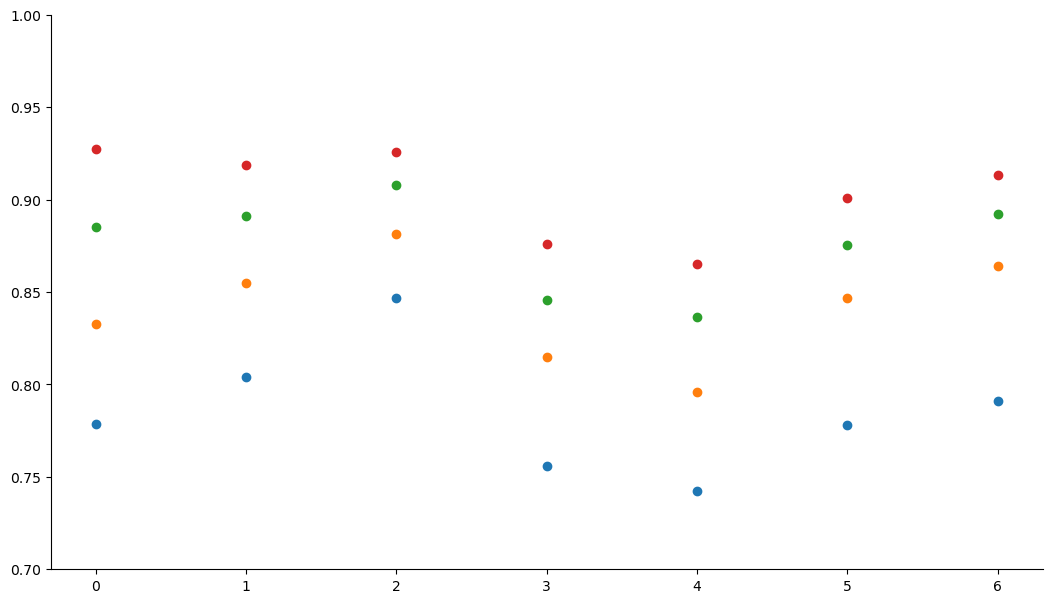

In [11]:
for n_svs in range(2, 6): 
    top_3_svs = [movement_pca.explained_variance_ratio_[:n_svs].sum(), calibration_pca.explained_variance_ratio_[:n_svs].sum()] + [c.explained_variance_ratio_[:n_svs].sum() for c in chunk_pcas]
    plt.plot(top_3_svs,"o")
    plt.ylim([0.7,1.0])

In [12]:
# movement_pca = PCA().fit(analysis.log_emg_data(movement_samples))
# calibration_pca = PCA().fit(analysis.log_emg_data(calibration_samples))
# chunk_pcas = []
# for chunk in trial_chunks:
#     chunk_pcas.append(PCA().fit(analysis.log_emg_data(chunk)))

In [13]:
# for n_svs in range(2, 6): 
#     top_3_svs = [movement_pca.explained_variance_ratio_[:n_svs].sum(), calibration_pca.explained_variance_ratio_[:n_svs].sum()] + [c.explained_variance_ratio_[:n_svs].sum() for c in chunk_pcas]
#     plt.plot(top_3_svs,"o")
#     plt.ylim([0.8,1.0])

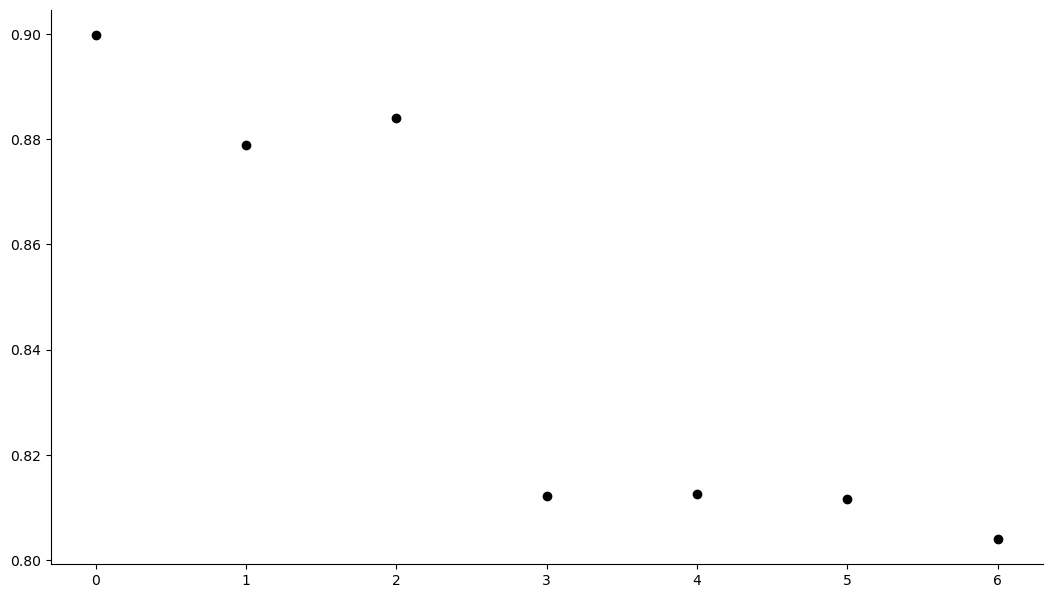

In [14]:
plt.plot([effective_rank(analysis.log_emg_data(movement_samples)), effective_rank(analysis.log_emg_data(calibration_samples))]+[effective_rank(analysis.log_emg_data(c)) for c in trial_chunks],"ko")

# over subjects

In [15]:
chunk_indices = list(zip(np.arange(0,45,9),np.arange(9,46,9)))
n_svs = 2
top_svs = []
for subject_idx in range(46):
    movement_stack = np.load("../subject_filtered_movement_stacks.npy")[subject_idx]
    calibration_stack = np.load("../subject_filtered_calibration_stacks.npy")[subject_idx]
    trial_stack = np.load(f"../filtered_stacks/filtered_stack_{subject_idx}.npy")

    movement_samples = analysis.remove_nan_rows(movement_stack.transpose(0,1,3,2).reshape(-1,64))
    calibration_samples = analysis.remove_nan_rows(calibration_stack.transpose(0,1,3,2).reshape(-1,64))

    trial_chunks = []
    for start, end in chunk_indices:
        s = trial_stack.transpose(0,1,3,2)[start:end].reshape(-1,64)
        ns = analysis.remove_nan_rows(s)
        trial_chunks.append(ns)

    # with log
    movement_pca = PCA().fit(analysis.log_emg_data(movement_samples))
    calibration_pca = PCA().fit(analysis.log_emg_data(calibration_samples))
    chunk_pcas = []
    for chunk in trial_chunks:
        chunk_pcas.append(PCA().fit(analysis.log_emg_data(chunk)))

    # without log 
    # movement_pca = PCA().fit(movement_samples)
    # calibration_pca = PCA().fit(calibration_samples)
    # chunk_pcas = []
    # for chunk in trial_chunks:
    #     chunk_pcas.append(PCA().fit(chunk))

    top_svs.append([movement_pca.explained_variance_ratio_[:n_svs].sum(), calibration_pca.explained_variance_ratio_[:n_svs].sum()] + [c.explained_variance_ratio_[:n_svs].sum() for c in chunk_pcas])
    

cut 1 samples
cut 2 samples
cut 70 samples
cut 2 samples
cut 5 samples
cut 8 samples
cut 3 samples
cut 33 samples
cut 25 samples
cut 54 samples
cut 52 samples


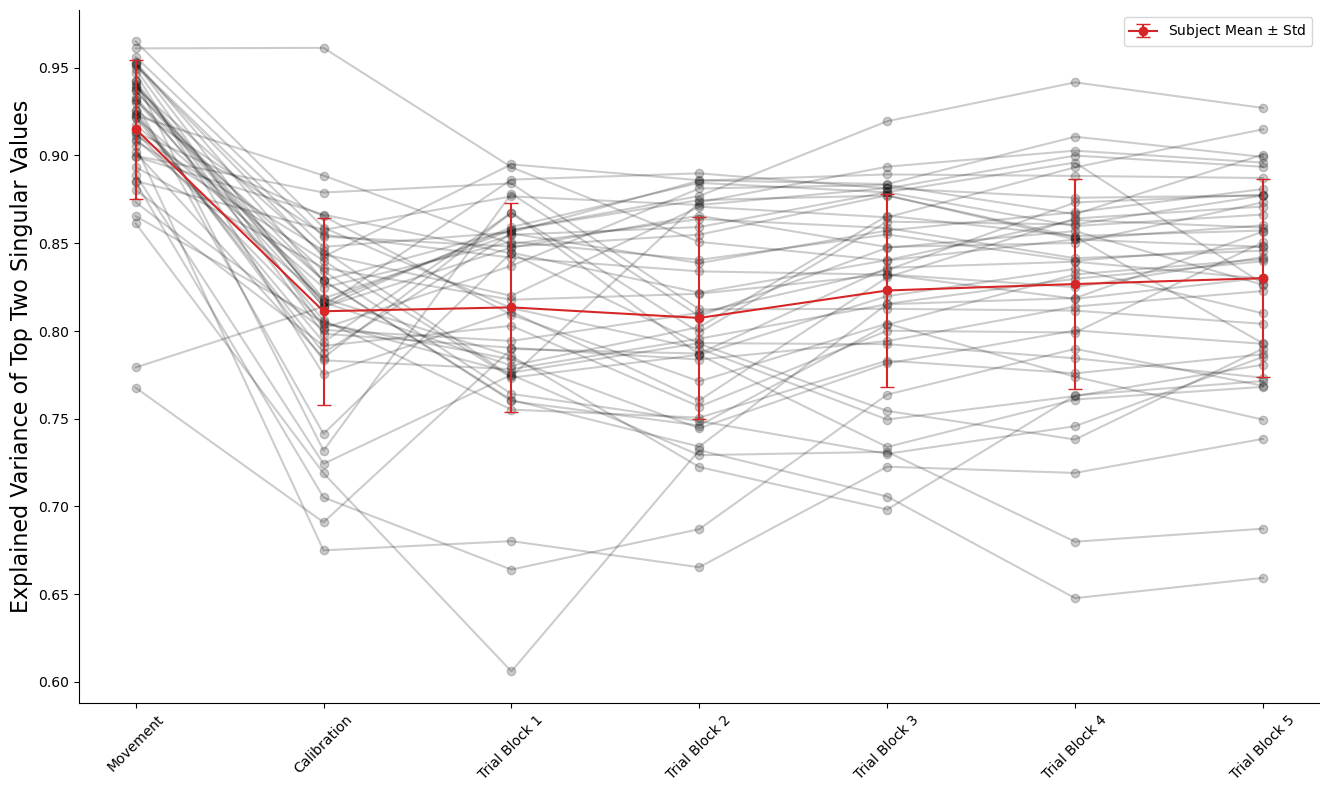

In [20]:
fig = plt.figure(figsize=(16,9))
xlabels = ["Movement", "Calibration"] + [f"Trial Block {i}" for i in range(1,6)]
for s in top_svs:
    plt.plot(s,"o-",color="k",alpha=0.2)
plt.errorbar(range(7),np.mean(top_svs,axis=0),yerr=np.std(top_svs,axis=0),linestyle="-",marker="o",color="tab:red",capsize=5,label="Subject Mean $\pm$ Std")
plt.xticks(range(7),labels=xlabels,rotation=45)
plt.ylabel("Explained Variance of Top Two Singular Values")
plt.legend()

In [19]:
plot.save_figure(fig, "PCA_rank_over_models", image_path)

Figure saved to /Users/spencer/phd/phd/images/basic_results/pca_dimensionality/PCA_rank_over_models.pdf


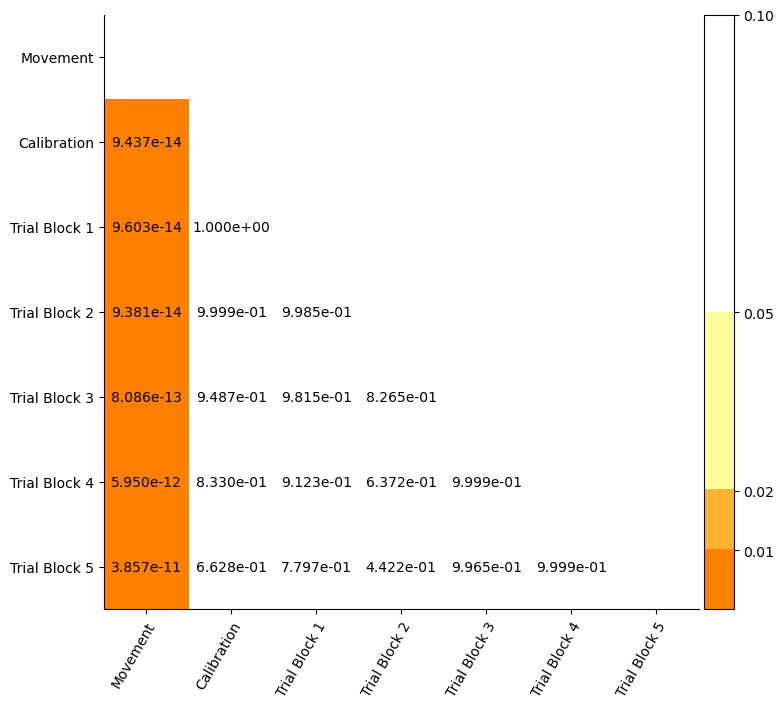

In [ ]:
result = tukey_hsd(*(np.array(top_svs).T))
pvalue_array_fig, _ = plot.annotated_heatmap(result.pvalue,xlabels,xlabels)

In [13]:
plot.save_figure(pvalue_array_fig, "pca_rank_pvalues",image_path,format="png")

Figure saved to /Users/spencer/phd/phd/images/basic_results/pca_dimensionality/PCA_variance.pdf
Figure saved to /Users/spencer/phd/phd/images/basic_results/pca_dimensionality/pca_pvalues.png


## pca rank vs reward

In [19]:
np.array(top_svs).shape

(46, 7)

0.21174037486640668
0.02287367959948005
0.005082439739469021
0.05977870144862762
0.22963852634013862
0.28323376707042286
0.3396816595283767


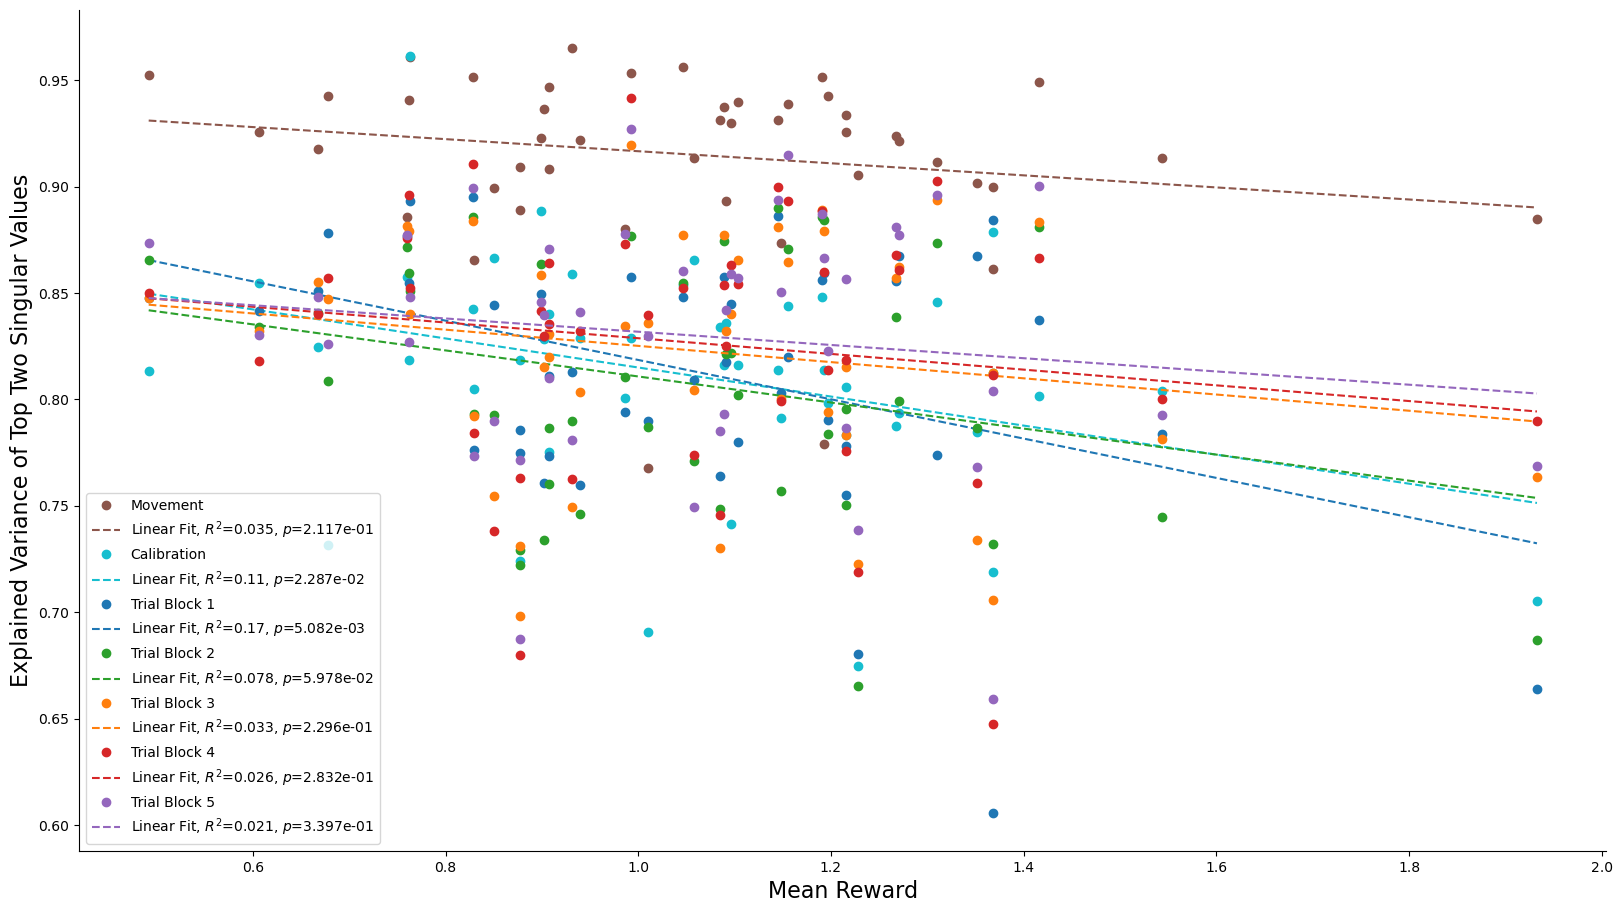

In [22]:
# subjects, model, component, singular vals
fig, ax = plt.subplots(1,1,figsize=(16,9))
fig.tight_layout()
c = ["tab:brown","tab:cyan","tab:blue","tab:green","tab:orange","tab:red","tab:purple",""]
for i, mean_sv in enumerate(np.array(top_svs).T):
    ax.plot(mean_rewards,mean_sv,'o',color=c[i],label=xlabels[i])
    res = analysis.linear_fit(mean_rewards, mean_sv)
    x = np.linspace(mean_rewards.min(),mean_rewards.max(),100)
    plot.plot_linear_fit(x, res, ax, color=c[i])
    ax.legend(ncols=1)
    ax.set_ylabel("Explained Variance of Top Two Singular Values")
    ax.set_xlabel("Mean Reward")
    print(res.pvalue)

In [23]:
plot.save_figure(fig, "pca_rank_vs_reward", image_path)

Figure saved to /Users/spencer/phd/phd/images/basic_results/pca_dimensionality/pca_rank_vs_reward.pdf


## visualize PCA modes

In [86]:
subject_idx = 24
chunk_indices = list(zip(np.arange(0,45,9),np.arange(9,46,9)))

movement_stack = np.load("../subject_filtered_movement_stacks.npy")[subject_idx]
calibration_stack = np.load("../subject_filtered_calibration_stacks.npy")[subject_idx]
trial_stack = np.load(f"../filtered_stacks/filtered_stack_{subject_idx}.npy")

movement_samples = analysis.remove_nan_rows(movement_stack.transpose(0,1,3,2).reshape(-1,64))
calibration_samples = analysis.remove_nan_rows(calibration_stack.transpose(0,1,3,2).reshape(-1,64))

trial_chunks = []
for start, end in chunk_indices:
    s = trial_stack.transpose(0,1,3,2)[start:end].reshape(-1,64)
    ns = analysis.remove_nan_rows(s)
    trial_chunks.append(ns)

# with log
movement_pca = PCA().fit(analysis.log_emg_data(movement_samples))
calibration_pca = PCA().fit(analysis.log_emg_data(calibration_samples))
chunk_pcas = []
for chunk in trial_chunks:
    chunk_pcas.append(PCA().fit(analysis.log_emg_data(chunk)))

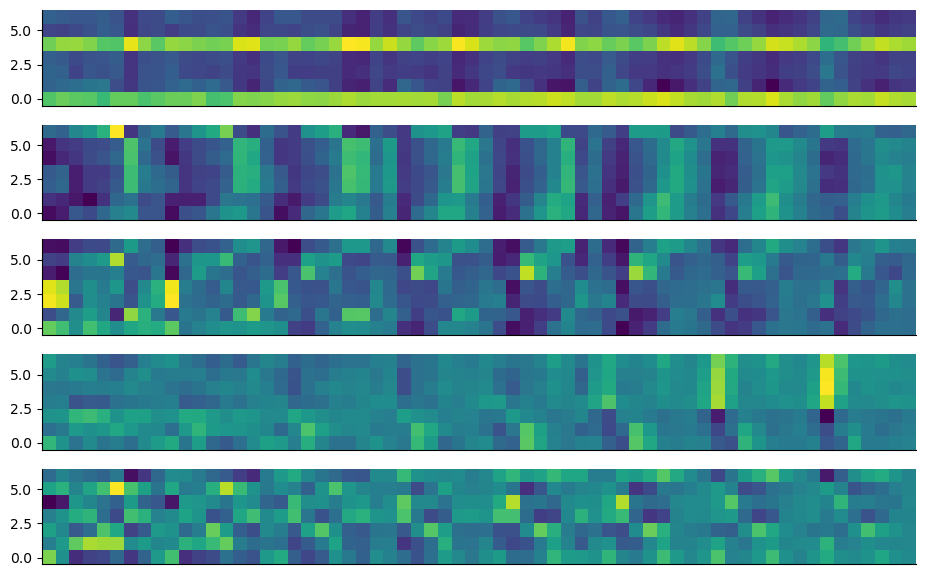

In [87]:
N = 5
fig, axes = plt.subplots(N,1)
for i in range(N):
    comps = np.concatenate([movement_pca.components_[i].reshape(1,64),calibration_pca.components_[i].reshape(1,64)] + [c.components_[i].reshape(1,64) for c in chunk_pcas])
    axes[i].imshow(comps,origin="lower")
    axes[i].set_xticks([])